$\qquad$ $\qquad$$\qquad$  **TDA 231 Machine Learning: Home Assignment 5 -- Clustering** <br />
$\qquad$ $\qquad$$\qquad$ **Goal: K-means (Yuchong), GMM (Divya), EM (Divya)**<br />
$\qquad$ $\qquad$$\qquad$                   **Grader: Yuchong, Divya** <br />
$\qquad$ $\qquad$$\qquad$                     **Due Date: 29th May** <br />
$\qquad$ $\qquad$$\qquad$                   **Submitted by: Pontus Havström, 970817-6459, ponhav@student.chalmers.se** <br />
$\qquad$ $\qquad$$\qquad$ **&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Qufei Wang, 900212-6952, qufei@student.chalmers.se**


---


General guidelines:
*   All solutions to theoretical and pratical problems must be submitted in this ipynb notebook, and equations wherever required, should be formatted using LaTeX math-mode.
*   All discussion regarding practical problems, along with solutions and plots should be specified in this notebook. All plots/results should be visible such that the notebook do not have to be run. But the code in the notebook should reproduce the plots/results if we choose to do so.
*   Your name, personal number and email address should be specified above.
*   All tables and other additional information should be included in this notebook.
*   **All the answers for theoretical questions must be filled in the cells created for you with "Your answer here" below each question, but feel free to add more cells if needed.**
*   Before submitting, make sure that your code can run on another computer. That all plots can show on another computer including all your writing. It is good to check if your code can run here: https://colab.research.google.com.


# Practical problems

The follwing code might be useful for this excercise.

```python
import scipy.io
mat = scipy.io.loadmat('hw5_p1a.mat')
print (mat.keys())
X = mat['X']
```

## [K-Means Implementation, 8 points]

Q 1.1. Implement the basic (linear) $k$-means algorithm as described in the lecture, using the euclidean distance. Use (uniformly) random points from the data as initialization for the centroids. Terminate the iterative procedure when the the cluster assignments do not change. [**4 pts**]

Q 1.2. Run your implementation on the matrix $X$ in **hw5_p1a.mat** with $k=2$. Each row of the matrix is an observation, and each column is a feature. Store the cluster assignment both after 2 iterations, and at convergence. Produce a scatter plot of the data with colors indicating the cluster assignments at convergence and highlight points that have changed assignment after the second iteration. [**4 pts**]

### Your answer here:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from google.colab import drive 
drive.mount('/content/drive') # To access files from drive (requires authorization)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the provided .mat file
import scipy.io
mat = scipy.io.loadmat('/content/drive/My Drive/TDA232/hw5_p1a.mat')
print (mat.keys())
X = mat['X']


dict_keys(['__header__', '__version__', '__globals__', 'X'])


### Q 1.1. Answer:

The basic $K$-means algorithm consists of the following iterative algorithm:

Initialization: \\
Choose the number of clusters $K$ \\
Guess the cluster positions $\mu_1$,$\dots$,$\mu_K$ \\
- Assign each data point $x_n$ to its closest cluster $\mu_k$ according to euclidean distance: 
$$d_{nk} = \sqrt{(x_n - \mu_k)^\mathrm{T}(x_n-\mu_k)}$$
- $z_{nk}$ = 1 if $x_n$ was assigned to $\mu_k$, otherwise $z_{nk} = 0$  
- Update $\mu_k$ to the average of all $x_n$ assigned to $\mu_k$:
$$\mu_k = \frac{\sum_{n=1}^N z_{nk}x_{n}}{\sum_{n=1}^N z_{nk}}$$
- Repeat until assignments do not change

A function is written that calculates the distances from an observation $x$ to all current $K$ means.

The centroids are initialized from uniformly random selections of the data using `numpy.random.randint` to select indices $n$ from $[0,N)$ (starting from 0 in Python). If the same point is selected more than once, the selection of index is ''re-rolled'' until an observation that has not previously been selected as a centroid is picked. This is to avoid ties in the unlikely case where several centroids are initialized as the same observation.

We utilize the fact that if the elements $z_{nk}$ are kept in a matrix $Z$, and if all elements of $Z$ are unchanged change between two iterations, the cluster assignments have not changed. Checking this after each iteration is used to determine when the iterative procedure is interrupted.

The current clusters are stored in a list, which is ''wiped'' with each new iteration as it is not required to compare this list with previous iterations when $Z$ is used to determine when the assignments do not change.

When storing intermediate results (for the second iteration), we store the centroids before updating them, since the clusters in iteration $2$ are assigned according to the centroids from iteration $1$.

In [0]:
def get_dists(x,mus):
  '''
    Calculate euclidean distance between a 2-dimensional observation x
    and all centroids in the matrix mus
    Inputs:
      x   = numpy array of size 2
      mus = 2-dimensional numpy array of size (K,2) where K is the number of 
            clusters
    Output:
      d   = numpy array of size (K,1) where each element is the euclidean
            distance from x to the corresponding centroid in mus
  '''
  K = mus.shape[0] # Get number of centroids
  d = np.zeros((K,1)) # Preallocate array of distances
  for k, mu in enumerate(mus):
    d[k] = np.sqrt((x-mu)@(x-mu))
  return d

In [0]:
from numpy import random

In [0]:
def K_means(X, K, store_intermediate=False):
  '''
      Performs a basic K-means algorithm on the two-dimensional data in the 
      matrix X
      Inputs: 
        X   = numpy 2-d array of size (N,2) where each row is an observation and
              each column is a feature
        K   = integer, the number of clusters used in the K-means algorithm
        store_intermediate  = an integer of the intermediate iteration before 
                              convergence at which to store the results, if none
                              given, no intermediate iteration is stored 
      Outputs: 
        mus   = 2-dimensional numpy array of size (K,2) where K is the number of 
              clusters, containing the updated cluster centroids
        C     = list of K clusters containing the observations assigned to each 
              centroid
        Z_new = 2-dimensional numpy array of size (N,K) of "one-hot" elements 
                znk after the final iteration
        count = integer, the number of iterations until convergence
        C_intermediate    = if store_intermediate was specified, this is the 
                          clusters of data after the specified iteration
        mus_intermediate  = if store_intermediate was specified, this is the 
                          centroids during the specified iteration
        Z_intermediate    = if store_intermediate was specified, this is a 
                            2-dimensional numpy array of size (N,K) of "one-hot" 
                            elements znk after the specified iteration
  '''
  N = X.shape[0] # Get number of observations in X

  # Initialize K centroids using uniformly random points from the data
  # Use discrete uniform distribution  over [0,N-1], allow replacement
  mus = np.zeros((K,2)) # Preallocate array of centroids
  n_used = np.array([]) # Preallocate list of data point indices already used for centroid initialization
  for k in range(K):
    while True:
      n_rand = np.random.randint(N)   # Discrete uniform distribution over [0,N)
      if n_rand not in n_used:        # Only accept points not previously selected as centroids
        break
    n_used = np.append(n_used,n_rand) # Store the selected index to not allow reselection
    mus[k] = X[n_rand,:]  # Assign the randomly chosen data point as centroid

  # Initialize (N,K) array of elements znk
  Z = np.zeros((N,K))      

  # Iterative loop:
  count = 0 # Initialize counting variable keeping track of number of iterations
  while True:
    # Initialize list of K clusters (list of K empty lists)
    C = [[] for i in range(K)]

    # Initialize updated (N,K) array of elements znk for this iteration
    Z_new = np.zeros((N,K))                                                      

    # Assign data to clusters
    for n, x in enumerate(X):
      d = get_dists(x,mus) # Calculate distances from x to all centroids
      k_min = min(range(len(d)), key=d.__getitem__) # Get index of minimum distance
      C[k_min].append(x) # Append x to the correct cluster
      Z_new[n,k_min] = 1 # Update "one-hot" element znk                               

    # Update iteration counter
    count += 1 

    # Store intermediate iteration result if specified
    if store_intermediate == False:
      C_intermediate = None
      mus_intermediate = None
      Z_intermediate = None
    if count == store_intermediate:
      C_intermediate = C
      mus_intermediate = np.zeros((K,2)) # Preallocate intermediate centroids
      for k in range(K):
        mus_intermediate[k] = mus[k]     # Assign intermediate centroids (before updating)
      Z_intermediate = Z_new

    # Update centroids
    for k in range(K):
      mus[k] = sum(C[k])/len(C[k])

    # Check if cluster assignments did not change ...
    if (Z_new == Z).all() == True: # ... by comparing Z-matrix to previous iteration
      break
    else: 
      Z = Z_new # If not, update Z-matrix

  # If iterations count did not reach specified intermediate iteration
  if count < store_intermediate:
    C_intermediate = None
    mus_intermediate = None
    Z_intermediate = None


  if store_intermediate == False:
    return mus, C, Z_new, count
  elif C_intermediate == None:
    print('The algorithm converged before the specified intermediate iteration.')
    return mus, C, Z_new, count, mus_intermediate, C_intermediate, Z_intermediate
  else: 
    return mus, C, Z_new, count, mus_intermediate, C_intermediate, Z_intermediate

Q 1.2. Answer:

In [0]:
# Run the K-means algorithm on the provided data in X with K = 2, 
# also store intermediate result after 2 iterations
K = 2
store_intermediate = 2
mus, C, Z, count, mus_i, C_i, Z_i = K_means(X, K, store_intermediate)
print(f'K-means algorithm converged after {count} iterations.')

K-means algorithm converged after 9 iterations.


In [0]:
cluster_changes = Z-Z_i     # Make array of difference between final Z-matrix and intermediate Z-matrix
cluster_changes = cluster_changes[:,0] # Get the first column (don't need both to identify changes)
# When -1, assignment changed from k=1 to k=2
# When  1, assignment changed from k=2 to k=1
# When  0, assignment stayed the same

print(cluster_changes)


[ 0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.
  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.
  1.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.
  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  1.  1.  0.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.
  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.
  0.  1.  1.  0.  0. -1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.
  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.
  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.
  1.  0.  1. -1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.
  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0

In [0]:
indices = np.arange(len(cluster_changes)) # Array of data indices
# Make array where elements match indices if assignment changed from k=1 to k=2
# turn all other elements to -1
k1to2 = np.where(cluster_changes == -1., indices, -1) 
# Make new array of indices corresponding to assignment changes from k=1 to k=2
# i.e. get rid of -1 elements
k1to2 = k1to2[k1to2!=-1]
print(k1to2)

[149 219]


In [0]:
# Make array where elements match indices if assignment changed from k=2 to k=1
# turn all other elements to -1
k2to1 = np.where(cluster_changes == 1., indices, -1) 
# Make new array of indices corresponding to assignment changes from k=2 to k=1
# i.e. get rid of -1 elements
k2to1 = k2to1[k2to1!=-1]
print(k2to1)

[  1   3   5   9  10  14  15  16  18  19  22  35  37  39  44  47  48  51
  52  53  54  56  57  62  65  66  67  68  69  72  74  75  79  80  81  86
  90  91  93  94  96  97  98 104 105 107 108 112 113 115 116 118 127 129
 132 135 136 137 143 145 146 150 153 154 156 161 162 163 165 167 168 170
 173 174 177 178 179 180 181 185 186 191 193 195 201 207 208 214 216 218
 223 224 227 228 231 234 235 237 241 243 245 247 248]


In [0]:
# Get elements of X that changed assignment
X_1to2 = X[k1to2]
X_2to1 = X[k2to1]

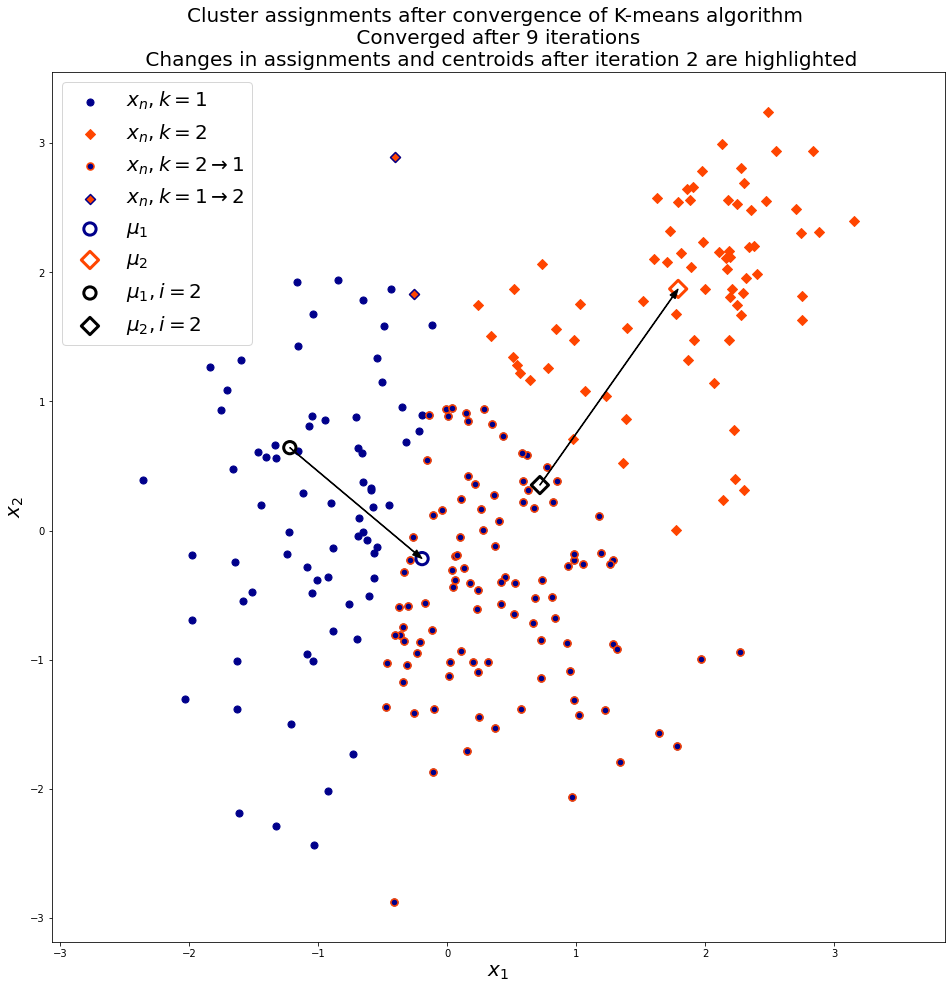

In [0]:
# Plot the resulting clusters with changes from intermediate iteration
C_1 = np.array(C[0]) # Cluster 1
C_2 = np.array(C[1]) # Cluster 2
C_i1 = np.array(C_i[0]) # Cluster 1 after 2 iterations
C_i2 = np.array(C_i[1]) # Cluster 2 after 2 iterations
color_1 = 'darkblue' # Color assigned to k=1
color_2 = 'orangered' # Color assigned to  k=2
f, ax = plt.subplots(1, 1, figsize = (16,16))
ax.scatter(C_1[:,0], C_1[:,1], s = 50, marker='o', color=color_1, label=r'$x_n, k=1$') # Cluster 1
ax.scatter(C_2[:,0], C_2[:,1], s = 50, marker='D', color=color_2, label=r'$x_n, k=2$') # Cluster 2
ax.scatter(X_2to1[:,0], X_2to1[:,1], s = 50, marker='o', color=color_1, edgecolors=color_2, linewidths=1.5, label=r'$x_n, k=2\rightarrow 1$') # Cluster change 2 -> 1
ax.scatter(X_1to2[:,0], X_1to2[:,1], s = 50, marker='D', color=color_2, edgecolors=color_1, linewidths=1.5, label=r'$x_n, k=1\rightarrow 2$') # Cluster change 1 -> 2
ax.scatter(mus[0,0], mus[0,1], s = 150, marker='o', color=color_1, facecolor='None', linewidths=3, label=r'$\mu_1$') # Centroid 1
ax.scatter(mus[1,0], mus[1,1], s = 150, marker='D', color=color_2, facecolor='None', linewidths=3, label=r'$\mu_2$') # Centroid 2
ax.scatter(mus_i[0,0], mus_i[0,1], s = 150, marker='o', color='black', facecolor='None', linewidths=3, label=fr'$\mu_1, i=${store_intermediate}') # Centroid 1 after 2 iterations
ax.scatter(mus_i[1,0], mus_i[1,1], s = 150, marker='D', color='black', facecolor='None', linewidths=3, label=fr'$\mu_2, i=${store_intermediate}') # Centroid 2 after 2 iterations
ax.arrow(mus_i[0,0],mus_i[0,1],mus[0,0]-mus_i[0,0],mus[0,1]-mus_i[0,1], color='black', width=.005, length_includes_head=True, head_width=.05)
ax.arrow(mus_i[1,0],mus_i[1,1],mus[1,0]-mus_i[1,0],mus[1,1]-mus_i[1,1], color='black', width=.005, length_includes_head=True, head_width=.05)
ax.set_xlabel(r'$x_1$', fontsize=20)
ax.set_ylabel(r'$x_2$', fontsize=20)
ax.set_title(f'Cluster assignments after convergence of K-means algorithm \n Converged after {count} iterations \n Changes in assignments and centroids after iteration {store_intermediate} are highlighted', fontsize=20)
ax.axis('equal')
ax.legend(fontsize=20);


The figure above shows the result from running the K-means algorithm. Here, the final clusters and centroids are plotted, where the two clusters are separated by color. The data for which the assignment changed after the second iteration is highlighted: the fill color shows final assignment, while the edge color shows assignment after the second iteration. The centroids after the second iteration are also shown, as well as how they moved after convergence.

$x_n,k=1$ are the observations assigned to cluster $k=1$, while $x_n,k=2$ are the observations assigned to cluster $k=2$. 

$x_n,k=2\rightarrow 1$ are the observations that were assigned to cluster $2$ after the second iteration but changed assignment to cluster $1$ after convergence.  Similarly, $x_n,k=1\rightarrow 2$ are the observations that were assigned to cluster $1$ after the second iteration but changed assignment to cluster $2$ after convergence. 

$\mu_1$ and $\mu_2$ are the centroids of cluster $k=1$ and $k=2$ after convergence, respectively. $\mu_1,i=2$ and $\mu_2,i=2$ are the centroids of cluster $k=1$ and $k=2$ during the assignment in the second iteration, respectively (before update in second iteration, as assignments are made based on centroids from previous iteration).

For clarity, we also plot the final result without the changes from the second iteration below:

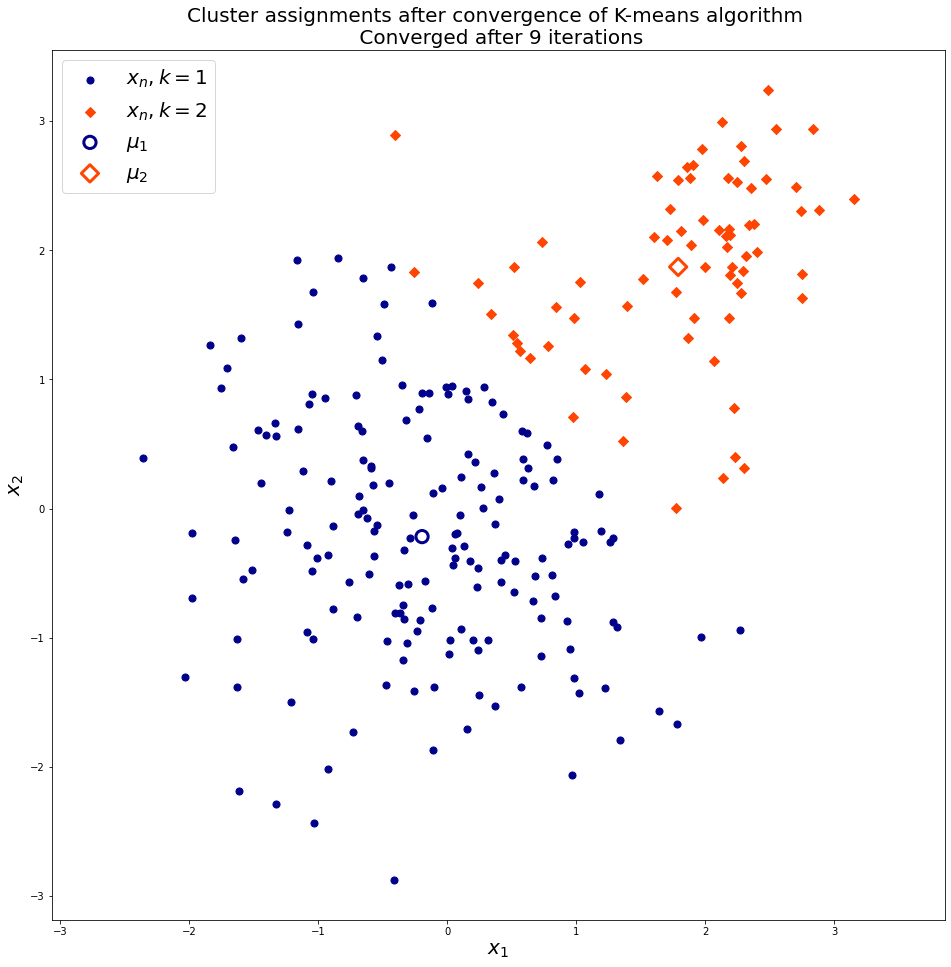

In [0]:
# Plot also only the final clusters and centroids
C_1 = np.array(C[0]) # Cluster 1
C_2 = np.array(C[1]) # Cluster 2
color_1 = 'darkblue' # Color assigned to k=1
color_2 = 'orangered' # Color assigned to  k=2
f, ax = plt.subplots(1, 1, figsize = (16,16))
ax.scatter(C_1[:,0], C_1[:,1], s = 50, marker='o', color=color_1, label=r'$x_n, k=1$') # Cluster 1
ax.scatter(C_2[:,0], C_2[:,1], s = 50, marker='D', color=color_2, label=r'$x_n, k=2$') # Cluster 2
ax.scatter(mus[0,0], mus[0,1], s = 150, marker='o', color=color_1, facecolor='None', linewidths=3, label=r'$\mu_1$') # Centroid 1
ax.scatter(mus[1,0], mus[1,1], s = 150, marker='D', color=color_2, facecolor='None', linewidths=3, label=r'$\mu_2$') # Centroid 2
ax.set_xlabel(r'$x_1$', fontsize=20)
ax.set_ylabel(r'$x_2$', fontsize=20)
ax.set_title(f'Cluster assignments after convergence of K-means algorithm \n Converged after {count} iterations', fontsize=20)
ax.axis('equal')
ax.legend(fontsize=20);

# GMM [4 pts]

We will now consider mixture model. The probability of an observation $x \in \mathbb{R}^D$ is given by: $$p(x) = \sum_{k=1}^{K} \pi_k P(x|\theta_k)$$ where $\pi_k$ are the probabilities a priori and $P(x|\theta_k)$ are multi-dimensional Gaussian characterized by their mean $\mu_k$ and their co-variance matrix $\Sigma_k$
, i.e. $\theta_k = (\mu_k, \Sigma_k)$.

### Q 2.1.
Plot the probability distribution $p(x)$ for D=1 , K = 2, $\pi_1 = \pi_2 = 0.5$ and $\mu_1 = 1$, $\mu_2 = 3$,$\Sigma_1 = 1$,$ \Sigma_2 = 10$. **[2 pts]**

### Q 2.2.

What is the posterior probability that an example $x=1.5$ was produced by the Gaussian $k=1$,i.e. $P(\theta_1| x)$ ? **[2 pts]**

### Your answer here:

### Q 2.1. Answer:

In [0]:
# Define gaussian distribution pdf (univariate since D=1 here)
def gauss(x, theta):
  mu = theta[0]
  Sigma = theta[1]
  P = 1/(np.sqrt(2*np.pi*Sigma))*np.exp(-1/2*((x-mu)**2)/Sigma)
  return P

In [0]:
# Define probability distribution of the mixture model
def GMM(x, K, pi, theta):
  p = np.zeros_like(x)
  for k in range(K):
    p += pi[k]*gauss(x, theta[k,:])
  return p

In [0]:
# Define parameters
D = 1 # Dimensionality of observations 
K = 2 # Number of mixture components
pi_1 = .5 # Probability a priori 1
pi_2 = .5 # Probability a priori 2
mu_1 = 1. # Mean of Gaussian 1
mu_2 = 3. # Mean of Gaussian 2
Sigma_1 = 1.  # Co-variance matrix of Gaussian 1 (in this case just a scalar)
Sigma_2 = 10. # Co-variance matrix of Gaussian 2 (in this case just a scalar)


theta = np.array([[mu_1, Sigma_1],
                  [mu_2, Sigma_2]])
pi = np.array([pi_1, pi_2])

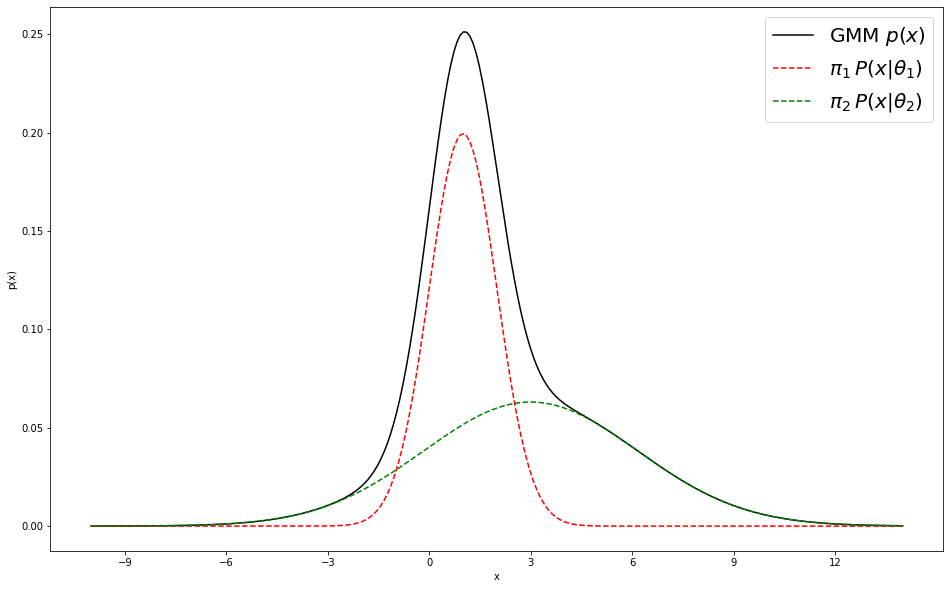

In [0]:
# Plot the pdf for the given parameters as well as the individual Gaussians
f, ax = plt.subplots(1, 1, figsize = (16,10))
x = np.linspace(-10,14,256)
p = GMM(x, K, pi, theta)
P_1 = gauss(x, theta[0,:])
P_2 = gauss(x, theta[1,:])
ax.plot(x, p, 'k', label = r'GMM $p(x)$')
ax.plot(x, pi_1*P_1, '--r', label = r'$\pi_1\:P(x|\theta_1)$')
ax.plot(x, pi_2*P_2,'--g', label = r'$\pi_2\:P(x|\theta_2)$')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_xticks([-9,-6,-3,-0,3,6,9,12])
ax.legend(fontsize=20)
plt.tight_layout;

### Q 2.2. Answer:

The posterior probability can be expressed using Bayes' rule: 
$$P(\theta_1|x) = \frac{P(\theta_1)P(x|\theta_1)}{P(x)} = \frac{P(\theta_1) P(x|\theta_1)}{P(\theta_1) P(x|\theta_1) + P(\theta_2) P(x|\theta_2)}$$

(Essentially calculating the *responsibility* for $k=1$ for a single data point)

The mixing coefficients are viewed as the prior probabilities: $$P(\theta_1) = \pi_1 = 0.5,\quad P(\theta_2) = \pi_2= 0.5$$

In [0]:
# Define function for calculating posterior probabilities for mixture of 2 Gaussians
def get_posterior(x, k, pi, theta):
  ''' 
      x     = observation
      k     = index of theta in posterior probability
      pi    = K-dimensional array of mixing coefficients (prior probabilities)
      theta = array of thetas
  '''
  k = k-1 # From indexing starting at 1 to 0
  K = len(pi)
  likelihood = np.zeros(K,)
  for i in range(K):
    likelihood[i] = gauss(x,theta[i,:])
  marg = np.sum(pi*likelihood)
  p = (pi[k]*likelihood[k])/marg
  return p

# Calculate the posterior probability
x = 1.5
likelihood_1 = gauss(x,theta[0,:])
likelihood_2 = gauss(x,theta[1,:])
posterior = get_posterior(x, 1, pi, theta)
print(f'Likelihood 1: {likelihood_1:.04}')
print(f'Likelihood 2: {likelihood_2:.04}')
print(f'Posterior probability: {posterior:.04} = {posterior*100:.04}%')

Likelihood 1: 0.3521
Likelihood 2: 0.1127
Posterior probability: 0.7575 = 75.75%


The posterior probability of $x=1.5$ being produced by the Gaussian $k=1$ is then given by 
$$P(\theta_1|x) = \frac{P(\theta_1) P(x|\theta_1)}{P(\theta_1) P(x|\theta_1) + P(\theta_2) P(x|\theta_2)} = \frac{0.5\cdot0.3521}{0.5\cdot0.3521 + 0.5\cdot0.1127} = 0.7575 = 75.75 \%$$

This relatively high probability seems reasonable by looking at the plot from the previous task, as $x=1.5$ is close to the mean of Gaussian $k=1$ ($\mu_1=1$) with a narrow variance ($\Sigma_1 = 1$), compared to Gaussian $k=2$ which has a higher mean and a larger variance.

# EM algorithm for GMM [8 pts]

Assume that the property prices of Gotheburg follow a mixture of 2 Gaussians, of respective parameters $(\mu_1, \sigma_1^2)$ and $(\mu_2, \sigma_2^2)$.

The table below lists the prices in million SEK of some real estate transactions:
$$\begin{array}{|c|c|c|c|}
\hline
8& 1 & 4 & 3 & 4 & 5 & 7 & 5 & 3 & 5 \\ \hline
\end{array}$$

We will call $\pi_1$ and $\pi_2$ the coefficients of the two Gaussians in the mixture. Note: $\theta^{i}$ denotes $i^{th}$ step estimate when using EM algorithm.

### Q 3.1.

Sort the items of the sample in ascending order and use the 5 smallest values for
estimating $(\mu_1, \sigma_1^2)$ and 5 larger ones to estimate $(\mu_2, \sigma_2^2)$. Under these conditions, what values should logically be assigned to the weights $\pi_1$ and $\pi_2$? **[2 pts]**

### Q 3.2.

Starting from $\theta^0 = \{\mu_1, \sigma^2_1, \pi_1, \mu_2, \sigma^2_2, \pi_2\}$ obtained from the previous question, estimate the value of responsibilities $\gamma(z_{nk})$ according to the EM algorithm. **[3 pts]**

### Q 3.3.
Re-estimate the parameters i.e. calculate $\theta^1$, using the current responsibilities.**[3 pts]**

### Your answer here:
### Answer 3.1 ###
Values that should logically be assigned to weights $\pi_1$ and $\pi_2$ is 0.5. Because there are 10 data samples in total and 5 of the smallest values are used to estimate $(\mu_1, \sigma_1^2)$, the other 5 are used to esitmiate $(\mu_2, \sigma_2^2)$. It is pretty logical to assign $\pi_1$ and $\pi_2$ with equal value 0.5, which could be viewd as the prior probability of $z_{nk} = 1$.

The code below uses the sample data to estimate $\mu_1, \sigma_1^2, \mu_2, \sigma_2^2$, which gives an estimation result of: 
$$\mu_1 = 3, \sigma_1^2 = 1.2 \\ \mu_2 = 6, \sigma_2^2 = 1.6$$

In [0]:
import numpy as np
data = np.array([8, 1, 4, 3, 4, 5, 7, 5, 3, 5], dtype=float)
sorted_data = np.sort(data)

group_1 = sorted_data[0:5]
group_2 = sorted_data[5:10]

mu_1 = np.mean(group_1)
sigma_1 = np.var(group_1)

mu_2 = np.mean(group_2)
sigma_2 = np.var(group_2)

print("Estimation of mean and variance:")
print("mu_1 : %f, sigma_1_square : %f" %(mu_1, sigma_1)) 
print("mu_2 : %f, sigma_2_square : %f" %(mu_2, sigma_2)) 

Estimation of mean and variance:
mu_1 : 3.000000, sigma_1_square : 1.200000
mu_2 : 6.000000, sigma_2_square : 1.600000


### Answer 3.2 ###
The EM altorithm specifies the following formula to estimate responsibilities $\gamma(z_{nk})$:
$$
\gamma(z_{nk}) = \frac{\pi_k\mathcal{N}(x_n | \mu_k, \sigma_k^2)}{\sum_j\pi_j\mathcal{N}(x_n|\mu_j,\sigma_j^2)}
$$
The following code is used to complete the estimation.

In [0]:
pi_1 = pi_2 = 0.5

class GaussianDistribution:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        
    def get_probability(self, val):
        n1 = np.sqrt(2 * np.pi * self.var)
        n2 = np.divide(1, n1)
        n3 = np.divide(np.square(val - self.mean), 2 * self.var)
        n4 = np.exp(-n3)
        return n2 * n4

gaussian_1 = GaussianDistribution(mu_1, sigma_1)
gaussian_2 = GaussianDistribution(mu_2, sigma_2)

def estimate_responsibility(n, k):
    data = sorted_data[n]
    (norm1, norm2) = (gaussian_1, gaussian_2) if k == 0 else (gaussian_2, gaussian_1)
    n1 = 0.5 * norm1.get_probability(data)
    n2 = n1 + 0.5 * norm2.get_probability(data)
    return np.divide(n1, n2)
    
responsibilities = np.zeros((2, 10))

print("Estimation of responsibilities:")
for k in range(2):
    for n in range(10):
        val = estimate_responsibility(n, k)
        responsibilities[k][n] = val
        print("gamma(z_%d,%d): %f" %(n + 1, k + 1, val))

Estimation of responsibilities:
gamma(z_1,1): 0.998148
gamma(z_2,1): 0.950562
gamma(z_3,1): 0.950562
gamma(z_4,1): 0.726547
gamma(z_5,1): 0.726547
gamma(z_6,1): 0.229643
gamma(z_7,1): 0.229643
gamma(z_8,1): 0.229643
gamma(z_9,1): 0.002005
gamma(z_10,1): 0.000121
gamma(z_1,2): 0.001852
gamma(z_2,2): 0.049438
gamma(z_3,2): 0.049438
gamma(z_4,2): 0.273453
gamma(z_5,2): 0.273453
gamma(z_6,2): 0.770357
gamma(z_7,2): 0.770357
gamma(z_8,2): 0.770357
gamma(z_9,2): 0.997995
gamma(z_10,2): 0.999879


### Answer 3.3 ####
The EM algorithm specifies the following formulas to re-estimate the parameters:
$$
\mu_k = \frac{1}{N_k}\sum_{n=1}^{N}\gamma(z_{nk})x_n \\ 
\pi_k = \frac{N_k}{N}, \, where\, N_k = \sum_{n=1}^{N}\gamma(z_{nk}) \\
\sigma_k^2 = \frac{1}{N_k}\sum_{n=1}^{N}\gamma(z_{nk})(x_n - \mu_k)^2
$$
The following code is used to complete the re-estimation.

In [0]:
print("Re-estimation of parameters:")
for k in range(2):
    row = responsibilities[k, :]
    n_k = np.sum(row)
    mu_k = np.dot(row, sorted_data) / n_k
    pi_k = n_k / 10
    var_k = np.dot(row, np.square(sorted_data - mu_k)) / n_k
    
    print("mu_%d = %f, sigma_square_%d = %f, pi_%d = %f" %((k + 1), mu_k, (k + 1), var_k, (k + 1), pi_k))

Re-estimation of parameters:
mu_1 = 3.148715, sigma_square_1 = 1.598663, pi_1 = 0.496969
mu_2 = 5.835001, sigma_square_2 = 2.090423, pi_2 = 0.503031
